## Script to train an RNN on a simple memory task. 

#### Description:

Task: The network is given 3 targets as an input with x,y coordinates and a feature 'size' which can take on different values (small, medium, large etc). The network needs to output the x,y coordinates of the targets organized in order of increasing size. The inputs are shuffled such that the targets are given in a random order to the network. 

Model: The model is a vanilla recurrent neural network, with an input layer corresponding to the task inputs above with 3 dimensions: x,y,s (x,y coordinates and the size feature). The input is of length T which is the trial duration or sequence length. The network also has an output layer of dimension 2 corresponding to the x and y coordinates. 

### Installing libraries

In [1]:
# Import libraries
import os
import math
import time
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from PIL import Image, ImageDraw
from torch.nn import init, functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import random_split, DataLoader, Dataset
#from torchvision import transforms


### Defining recurrent neural network

In [2]:
class CTRNN(nn.Module): # to create a recurrent neural network with an input layer (does not have an output layer yet)
    def __init__(self, input_size, hidden_size, **kwargs):
        # define all the network params
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.device = "cpu" # ("mps" if torch.backends.mps.is_available() else "cpu") # define device as machine gpu
        self.tau = kwargs.get('tau', 50)                                      # time constant of the network 
        self.bias = kwargs.get('bias', False)                                 # bias weights to be set to 0 as default or 'False'
        self.dt = kwargs.get('dt', 1)                                         # time step for the continuous time recurrent neural network 
        self.train_initial_state = kwargs.get('train_initial_state', True)    # whether to train the initial condition of the network or not
        self.alpha = self.dt / self.tau                                       # in most cases dt = 1ms and tau = 50.
        # default definition of input and recurrent weights
        self.input2h = nn.Linear(input_size, hidden_size, bias=self.bias).to(self.device) 
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=self.bias).to(self.device)
        
        # initialize the input and hidden weights
        init.normal_(self.input2h.weight, mean=0, std=0.5)
        init.normal_(self.h2h.weight, mean=0, std=1/np.sqrt(hidden_size)) # initialize recurrent weights to g/sqrt(N) (with spectral radius of 1)

        if self.train_initial_state: # if we want to train initial conditions of the network
            # initial_hidden_tensor = torch.zeros(1, hidden_size, requires_grad=True,device=self.device) # if you want to initialize the network activity to 0s 
            initial_hidden_tensor = torch.rand(1, self.hidden_size, requires_grad=self.train_initial_state, device=self.device) * 2 - 1
            self.initial_hidden = nn.Parameter(initial_hidden_tensor)
            self.register_parameter('initial_hidden', self.initial_hidden)
        else:
            initial_hidden_tensor = torch.zeros(1, hidden_size, requires_grad=False)
            self.register_buffer('initial_hidden', initial_hidden_tensor)  # Using register_buffer for non-trainable tensors
        self.to(self.device)

    def init_hidden(self, batch_size):
        # return torch.zeros(batch_size, self.hidden_size, device=self.device)
        return self.initial_hidden.repeat(batch_size, 1)

    def recurrence(self, input, hidden): # define dynamics of the rnn
        h_new = torch.tanh(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        h_new = h_new.to(self.device)
        return h_new

    def forward(self, input, hidden=None):
        input = input.to(self.device)
        if hidden is None:
            hidden = self.init_hidden(input.shape[1]) # Use the learnable initial hidden state
        output = []
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)
        output = torch.stack(output, dim=0)
        return output, hidden
        

class RNNNet(nn.Module): # to create the full model with the recurrent part above and an output layer
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()
        self.bias = kwargs.get('bias', False)
        self.device = "cpu" #("mps" if torch.backends.mps.is_available() else "cpu")
        self.rnn = CTRNN(input_size, hidden_size, **kwargs).to(self.device) # continuous time RNN
        self.fc = nn.Linear(hidden_size, output_size,bias=self.bias).to(self.device) # add linear readout layer
        init.normal_(self.fc.weight, mean=0, std=0.5) 


    def forward(self, x, hidden=None):
        x = x.to(self.device) # input tensor of shape (Seq Len, Batch, Input Dim)
        rnn_output, _ = self.rnn(x,hidden=hidden) # get activity of the rnn 
        out = self.fc(rnn_output) # linear output to the activity of the rnn
        return out, rnn_output

### Run model test

Std of initial connectivity matrix is tensor(0.0446, grad_fn=<StdBackward0>)

Input of shape (SeqLen, BatchSize, InputDim)= torch.Size([1000, 20, 2])
Output of shape (SeqLen, BatchSize, OutputDim)= torch.Size([1000, 20, 2])
Activity of neurons of shape (SeqLen, BatchSize, NumNeurons)= torch.Size([1000, 20, 500])

Model:
RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=2, out_features=500, bias=False)
    (h2h): Linear(in_features=500, out_features=500, bias=False)
  )
  (fc): Linear(in_features=500, out_features=2, bias=False)
)
Network activity with I=0


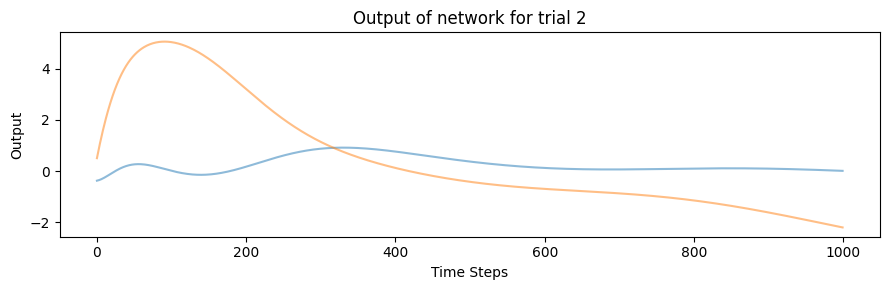

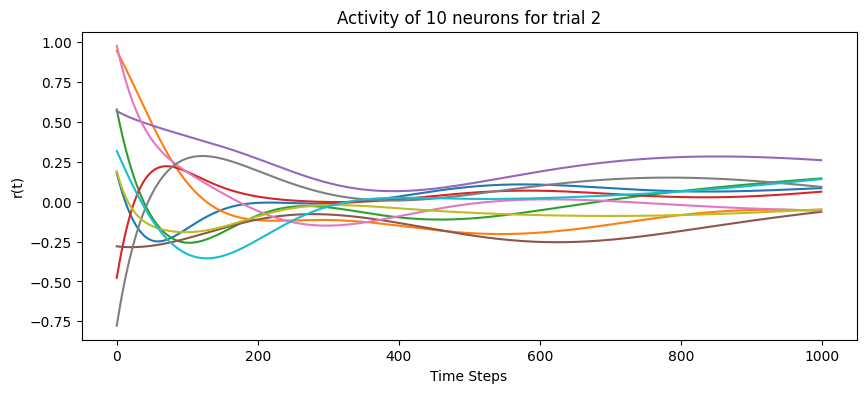

In [11]:
# check if gpu is available
device = "cpu"# ("mps" if torch.backends.mps.is_available() else "cpu") # *this line is mac M2/M3 specific

# Verify model structure on random input and for one time step

batch_size = 20             # size of data batch for training 
seq_len = 1000              # sequence length
input_size = 2              # input dimension
output_size = 2             # output dimension
hidden_size = 500           # number of neurons in the recurrent network or "hidden layer"
train_initial_state = True  # whether we want to train the initial state of the network

# Create a network instance 
model_test = RNNNet(tau = 50, input_size=input_size, hidden_size=hidden_size, output_size=output_size, bias=False, train_initial_state=train_initial_state)
model_test = model_test.to(device) # move to gpu 
h0 = model_test.rnn.h2h.weight
print('Std of initial connectivity matrix is ' + str(h0.std()))
print('')

# Create some random inputs
I = False # False if no input (zeros) and True if random input to network)
input = I * torch.randn(input_size) * torch.ones(seq_len, batch_size, input_size) # create a constant input of random amplitudes for each unit in the network 

# Run the sequence through the rnn network once
out, rnn_output = model_test(input) 
print('Input of shape (SeqLen, BatchSize, InputDim)=', input.shape)
print('Output of shape (SeqLen, BatchSize, OutputDim)=', out.shape)
print('Activity of neurons of shape (SeqLen, BatchSize, NumNeurons)=', rnn_output.shape)

print('')
print('Model:')
print(model_test)

print('Network activity with I=0')
numb_neurons = rnn_output.shape[2]
r_idx = np.random.choice(np.arange(numb_neurons), 10, replace=False) # choose 10 random neurons
time_steps = np.arange(out.shape[0]) # or 0 depends on above
idx = random.randint(0,20-1) # get index to random trial

# Move output to cpu to plot
rnn_output = rnn_output.cpu().detach().numpy()
out = out.cpu().detach().numpy()
# print(out.shape)

plot = True
if plot:
    plt.figure(figsize=(9, 3))
    for i in range(output_size):
        plt.plot(time_steps, out[:, idx, i],label='Output '+ str(int(i+1)),alpha=0.5)
        plt.title(f'Output of network for trial {idx}')
        # plt.axis([-1, seq_len, -5, 120])
        plt.xlabel('Time Steps')
        plt.ylabel('Output')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    for i in r_idx:
        plt.plot(time_steps, rnn_output[:,idx,i], label='X Coordinate')
    plt.title(f'Activity of 10 neurons for trial {idx}')
    plt.xlabel('Time Steps')
    plt.ylabel('r(t)')
    
    initial_h2h_weights = model_test.rnn.h2h.weight.data.cpu().detach().numpy()
    
    # # Plot the distribution
    # plt.figure(figsize=(9, 4))
    # plt.hist(initial_h2h_weights.flatten(), bins=50, alpha=0.75, color='blue')
    # plt.title("Distribution of Initial Recurrent Weights (h2h)")
    # plt.xlabel("Weight Value")
    # plt.ylabel("Frequency")
    # plt.grid(True)
    # plt.show()

    # # Plot the distribution of the output weights
    # output_weights = model_test.fc.weight.detach().cpu().numpy()
    # plt.hist(output_weights.flatten(), bins=30, edgecolor='k')
    # plt.title('Distribution of Output Weights')
    # plt.xlabel('Weight Value')
    # plt.ylabel('Frequency')
    # plt.show()


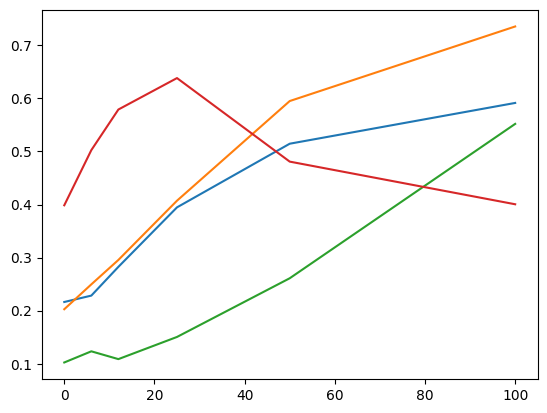

In [4]:
import scipy
data_path = '/Users/dellacc/Library/CloudStorage/OneDrive-TheFrancisCrickInstitute/cajal comp neuroscience 2024/Project - Palmigiano/Data_cell_types_small_size.mat'
data=scipy.io.loadmat(data_path,squeeze_me=True)
keys_to_delete = [key for key in data if key.startswith('_')]
for key in keys_to_delete:
          del data[key]
contrast=data['contrast']
del data['contrast']

for key in data.keys():
          plt.plot(contrast,np.nanmean(data[key],axis=0))

### Define all function for task (to change for a different task)

In [6]:
this_n=torch.randn(1)
nT = 10
input=torch.ones(nT)*this_n
output=torch.ones((2,nT))*this_n

##### pad input and ouput before and after gocue
input_tensor = input
output_tensor = output

In [12]:
class fdr_task(Dataset):
    def __init__(self,N=1000,nT=1000, **kwargs):
        self.inputs = []
        self.outputs = []
        self.N  = kwargs.get('N', 1000)
        self.nT = kwargs.get('nT', 1000)

        for _ in range(N):

            this_n=np.abs(np.random.randn())
            input=np.ones((1,nT))*this_n
            output=np.outer(np.array([this_n**2,this_n**3]),np.ones((1,nT)))

            ##### pad input and ouput before and after gocue
            input_tensor = torch.from_numpy(input)
            output_tensor = torch.from_numpy(output)

            self.inputs.append(input_tensor)
            self.outputs.append(output_tensor)

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx], self.inputs[idx].shape[1]



In [13]:
def plot_trial(sample_input, sample_output):
          plt.figure(figsize=(9, 3))
          plt.subplot(1, 2, 1)
          for k in range(sample_input.shape[0]):
                    plt.plot(sample_input[k,:], label=str(i),color="red")
          plt.xlabel('time')
          plt.subplot(1, 2, 2)
          for k in range(sample_output.shape[0]):
                    plt.plot(sample_output[k,:],label=str(i), color="orange")
                    


### Generate training dataset 

Plotting sample trial: 676
dataset trial length:1000


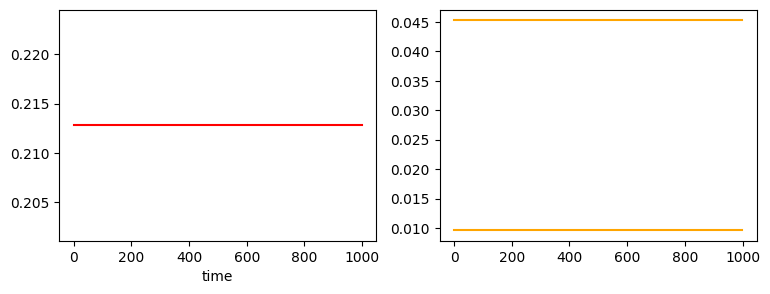

In [14]:
N = 1000 
nT=1000
task_type = 'fdr'

# define parameters for the task *task specific information that is not relevant for the network
config = { 
    'N': N,         # number of trials to generate
    'nT': nT, # number of targets in the task that the network has to organize
}

# create training data set
dataset = fdr_task(**config) 

# Seperate data into training, testing and validation sets
train_size = int(N * 0.7) # 70% for training
val_size = int(N * 0.15)  # 15% for validation
test_size = N - (train_size + val_size)  # Remaining 15% for testing
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # split data

batch_size = 32  # Adjust batch size according to your needs
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=None)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# generate one batch of data when called (for training)
input_sequence, target_sequence, l = next(iter(train_loader)) # Dims: batch x input dim x seq len ;  batch x output dim x seq len; batch x 1

# plot random trial 
for n in range(1):
    i = random.randint(0,train_size)
    sample_input, sample_output, l = dataset[i]
    print('Plotting sample trial: ' + str(int(i)))
    print('dataset trial length:' + str(l))
    sample_input_np = sample_input.numpy()
    sample_output_np = sample_output.numpy()
    plot_trial(sample_input_np,sample_output_np)
 
 

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


### Define training function for network

In [124]:
def train_model(model, train_loader, numb_epochs, continue_training=False, optimizer=None, losses=[], bias=False):

    # if training was paused
    if not continue_training or optimizer is None: 
        optimizer = optim.Adam(model.parameters(), lr=0.1) # define optimization (pytorch tools). "lr" is learning rate for adam optimizer
        losses = [] # to save losses during training
    
    criterion = nn.MSELoss() # criterion = nn.CrossEntropyLoss()
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [200,500,1000,2000,5000,7000,10000,15000,20000], gamma = 0.5) # learning rate scheduler

    running_loss = 0 # initialize running loss
    start_time = time.time()
    print('Training network...')
    for i in range(numb_epochs): # loop over epochs/over training batches; calls different batches of the data
        
        # create next batch of training data
        inputs, target, l = next(iter(train_loader)) 

        # reshape data 
        inputs = inputs.permute(2, 0, 1).float() # Input has shape (SeqLen, Batch, Dim)
        target = target.permute(2, 0, 1).float() # Target has shape (SeqLen, Batch,Dim)
        inputs = inputs.to('cpu')#inputs.to('mps')
        target = target.to('cpu')#target.to('mps')

        ## reshape target accordingly!

        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = model(inputs) # get output of the network
        output = output.float() # Reshape to (SeqLen x Batch, OutputSize)
        loss = criterion(output, target) # make sure everything is of the same size
            
        losses.append(loss.item())
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 20) # if you want to clip 
        optimizer.step()
        # scheduler.step() # to uncomment if you want to use optimization scheduler  


        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            running_loss = 0
    return model, losses, optimizer

### Training the network to perform the task

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=1, out_features=50, bias=False)
    (h2h): Linear(in_features=50, out_features=50, bias=False)
  )
  (fc): Linear(in_features=50, out_features=2, bias=False)
)
Training network...
Step 100, Loss 4.6566, Time 18.5s
Step 200, Loss 2.3426, Time 36.9s
Step 300, Loss 1.5397, Time 54.9s
Step 400, Loss 2.2872, Time 72.8s
Step 500, Loss 0.8078, Time 90.8s
Step 600, Loss 1.4308, Time 109.3s
Step 700, Loss 2.2624, Time 127.5s
Step 800, Loss 0.3142, Time 145.9s
Step 900, Loss 1.8518, Time 164.2s
Step 1000, Loss 2.0095, Time 182.4s
Loss is still high (2.0282). Continuing training...
Training network...
Step 100, Loss 0.7244, Time 18.0s
Step 200, Loss 1.5056, Time 36.2s


KeyboardInterrupt: 

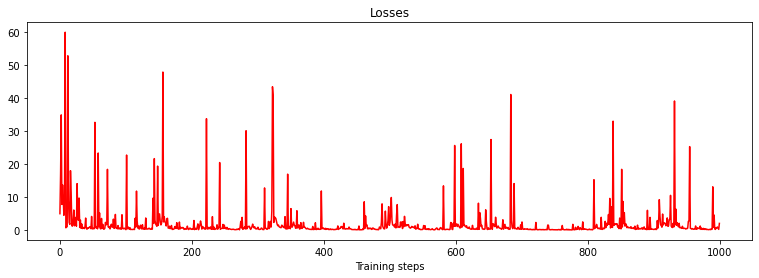

In [125]:
# Network Parameters
hidden_size = 50                        # number of neurons 
input_size = sample_input_np.shape[0]    # input dimension 
output_size = sample_output_np.shape[0]  # output dimension
dt = 1                                   # 1ms time step
numb_epochs = 1000                       # number of training epochs (each training epoch run through a batch of data)

# Create an instanciation of the model with the specification of the task above
model = RNNNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=dt, bias=False,tau=50,train_initial_state=True)
print(model)

continue_training = False # to avoid re-initialization of the network if training is paused

# run training
model, losses, optimizer = train_model(model, train_loader, numb_epochs=numb_epochs,continue_training=continue_training)
model_pred = model

# plot loss during training
plt.figure(figsize=(13, 4))
plt.plot(losses, color="red")
plt.xlabel("Training steps")
plt.title("Losses")


# run training again if loss is still too high
training_stop_threshold = 0.0001 # loss value at which to stop training 
if losses[-1] > training_stop_threshold:
    while losses[-1] > training_stop_threshold: 
        update_loss = losses[-1]
        print(f"Loss is still high ({losses[-1]:.4f}). Continuing training...")
        additional_epochs = 2000  # Define how many more epochs you want to train
        model, losses, optimizer = train_model(model, train_loader, numb_epochs=additional_epochs, continue_training=True, optimizer=optimizer, losses=losses)
        if abs(update_loss - losses[-1]) < 1: # (max_val*l*0.1/100): # to update if the error is stuck in a certain range
            break
        update_loss = losses[-1]
    
    # plot loss during training 
    plt.figure(figsize=(13, 4))
    plt.plot(losses, color="red")
    plt.xlabel("Training steps")
    plt.title("Losses")


### Test network after training, record activity and output

torch.Size([1000, 20, 1])


Text(0, 0.5, 'r(t)')

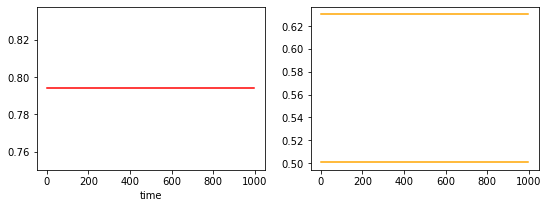

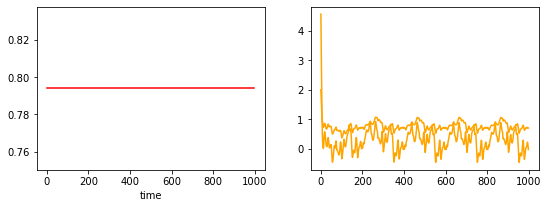

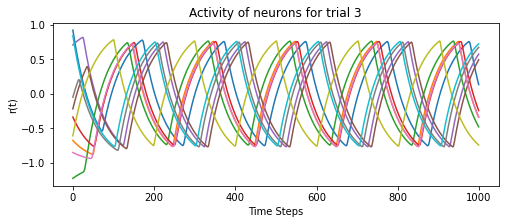

In [128]:
# testing config
test_size = 20
config['N'] = test_size

# generate testing data
test_dataset = fdr_task(**config) # create training data set
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=False) 
inputs, targets, seq_length = next(iter(test_loader)) # create next batch of testing data
inputs = inputs.permute(2, 0, 1).float()
targets = targets.permute(2, 0, 1).float()

# input_rnn_zeros = torch.zeros(seq_len, batch_size, input_size)
outputs, rnn_activity = model(inputs) # get predictions

random.seed()
numb_neurons = rnn_activity.shape[2]
r_idx = np.random.choice(np.arange(numb_neurons), 10, replace=False) # choose 10 random neurons
time_steps = np.arange(inputs.shape[0]) # or 0 depends on above
idx = random.randint(0,test_size-1)

print(inputs.shape)
inputs = inputs.cpu().detach().numpy()
targets = targets.cpu().detach().numpy()
outputs = outputs.cpu().detach().numpy()
rnn_activity = rnn_activity.cpu().detach().numpy()

trial_idx = random.randint(0,inputs.shape[1]-1) # choose random trial to plot
l = seq_length[0].numpy()
# print(l)
input  = inputs[:, trial_idx, :].T
target = targets[:, trial_idx, :].T
output = outputs[:, trial_idx, :].T

# print(sample_input_np.shape)
# print(input.shape)
config['sample_output'] = output # add network output to config 
config['post_training'] = True # add network output to config 
plot_trial(input,target)
plot_trial(input,output)

plt.figure(figsize=(8, 3))
for i in r_idx:
    plt.plot(time_steps, rnn_activity[:,idx,i], label='X Coordinate')
plt.title(f'Activity of neurons for trial {idx}')
plt.xlabel('Time Steps')
plt.ylabel('r(t)')

